

# LSTM implemented in Keras for Stock Prediction ( Time Series )



In [36]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# mount Google Drive to access Data
!fusermount -u drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls "gdrive/My Drive/Colab Notebooks/Data"

# Get NASDAQ data ( https://finance.yahoo.com/quote/GOOG/history/ ) and print 
stock_data = pd.read_csv("gdrive/My Drive/Colab Notebooks/Data/GOOG.csv")
stock_data.info()

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/gdrive
_about.txt  events.root  jet_images.h5		ntuple_ggH_ZZ4mu.root
deu.txt     GOOG.csv	 ntuple_bkg_ZZ4mu.root	ntuple_qqH_ZZ4mu.root
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date         1258 non-null object
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Adj Close    1258 non-null float64
Volume       1258 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


**We will take the average of the low and high of the Google stock for the day and volume of the stocks traded for the day to predict the stock prices.**

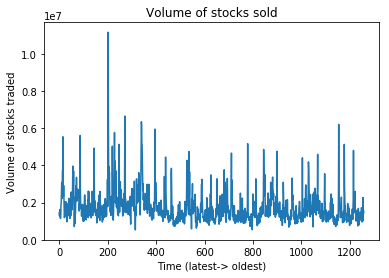

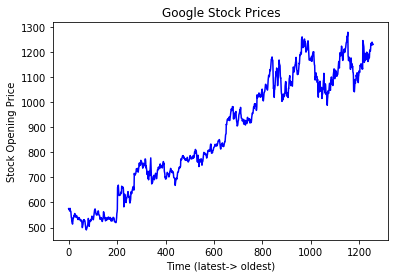

In [37]:
import math

# take the average of the low and high of the Google stock for the day
stock_data["average"] = (stock_data["High"] + stock_data["Low"])/2
stock_data.head(2)

# take the volume and average stock price as our input features and store it in input_data
input_feature= stock_data.iloc[:,[6,7]].values
input_data = input_feature

# plot the data for volume for the Google stocks traded for the day
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()


# plot the data for the average price for the day the Google stock
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

# Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])



**The time series data for today should contain the [Volume of stocks traded, Average stock price] for past 50 days and the target variable will be Google’s stock price today and so on. As the stock price prediction is based on multiple input features, it is a multivariate regression problem.**

In [0]:
lookback= 50

test_size=int(.3 * len(stock_data))
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])


**LSTM expects the input data in a specific 3D format of test sample size, time steps, no. of input features. In our case timesteps is 50, number of input features is 2(volume of stocks traded and the average stock price).**

In [39]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(1207, 50, 2)
(427, 50, 2)


**Build the LSTM**

In [40]:
from keras import Sequential
from keras.layers import Dense, LSTM

# define the LSTM architecture 
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

# compile 
model.compile(optimizer='adam', loss='mean_squared_error')

# train the network
history = model.fit(X, y, epochs=30, batch_size=20 , verbose=1 , validation_split=0.2)



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50, 30)            3960      
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 30)            7320      
_________________________________________________________________
lstm_24 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________
Train on 965 samples, validate on 242 samples
Epoch 1/30
965/965 [==============================] - 16s 17ms/step - loss: 0.0454 - val_loss: 0.0069
Epoch 2/30
965/965 [==============================] - 12s 12ms/step - loss: 0.0018 - val_loss: 0.003

**Make predictions and plot performance**

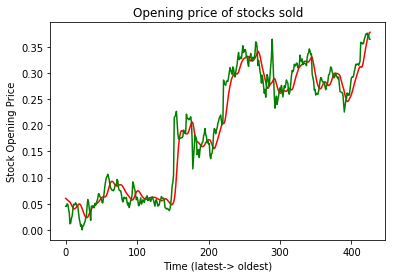

Text(0, 0.5, 'Loss')

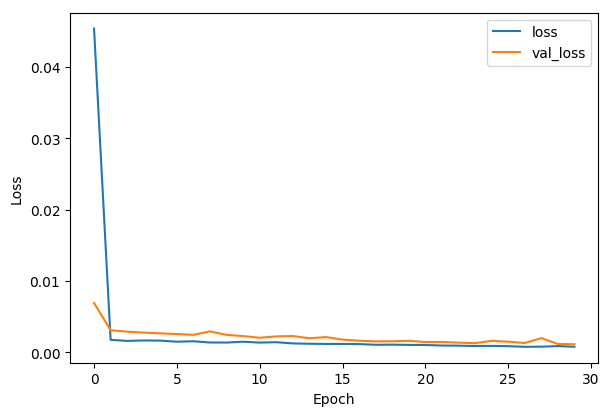

In [41]:
# make predictions
predicted_value= model.predict(X_test)

# plot the predictions
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

# plot performance
plt.style.use('default')
plt.figure(figsize=(15,10))

ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
#ax.set_ylim([0, 1])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

